In [86]:
from pyexpat import features
import random
import math
import os
from turtle import shape
from xml.sax.handler import property_interning_dict
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
from sklearn import linear_model, svm, discriminant_analysis, metrics
from scipy import optimize
import seaborn as sns
from joblib import dump, load
import csv



In [63]:

# Provides the methods to create and solve the firefighter problem
class FFP:

  # Constructor
  #   fileName = The name of the file that contains the FFP instance
  def __init__(self, fileName):
    file = open(fileName, "r")    
    text = file.read()    
    tokens = text.split()
    seed = int(tokens.pop(0))
    self.n = int(tokens.pop(0))
    model = int(tokens.pop(0))  
    self.result = 0
    self.featuresActualState = []
    self.trainingFeatures = [] #X, features results
    self.trainingClass = [] #Y, heuristic
    int(tokens.pop(0)) # Ignored
    # self.state contains the state of each node
    #    -1 On fire
    #     0 Available for analysis
    #     1 Protected
    self.state = [0] * self.n
    nbBurning = int(tokens.pop(0))
    for i in range(nbBurning):
      b = int(tokens.pop(0))
      self.state[b] = -1      
    self.graph = []    
    for i in range(self.n):
      self.graph.append([0] * self.n);
    while tokens:
      x = int(tokens.pop(0))
      y = int(tokens.pop(0))
      self.graph[x][y] = 1
      self.graph[y][x] = 1    

  # Solves the FFP by using a given method and a number of firefighters
  #   method = Either a string with the name of one available heuristic or an object of class HyperHeuristic
  #   nbFighters = The number of available firefighters per turn
  #   debug = A flag to indicate if debugging messages are shown or not
  def solve(self, method, nbFighters, debug = False):
    spreading = True
    if (debug):
      print("Initial state:" + str(self.state))    
    t = 0
    while (spreading):
      #always in order/
      # EDGE_DENSITY AVG_DEGREE BURNING_NODES BURNING_EDGES NODES_IN_DANGER
      featuresList = []
      featuresList.append(self.getFeature("EDGE_DENSITY"));
      featuresList.append(self.getFeature("AVG_DEGREE"));
      featuresList.append(self.getFeature("BURNING_NODES"));
      featuresList.append(self.getFeature("BURNING_EDGES"));
      featuresList.append(self.getFeature("NODES_IN_DANGER"));
      self.featuresActualState = featuresList
      self.trainingFeatures.append(featuresList)
      if (debug):
        print("Features")
        print("")
        print("Graph density: %1.4f" % (self.getFeature("EDGE_DENSITY")))
        print("Average degree: %1.4f" % (self.getFeature("AVG_DEGREE")))
        print("Burning nodes: %1.4f" % self.getFeature("BURNING_NODES"))
        print("Burning edges: %1.4f" % self.getFeature("BURNING_EDGES"))
        print("Nodes in danger: %1.4f" % self.getFeature("NODES_IN_DANGER"))
      # It protects the nodes (based on the number of available firefighters)
      for i in range(nbFighters):
        heuristic = method
        if (isinstance(method, HyperHeuristic)):
          heuristic = method.nextHeuristic(self)
        node = self.__nextNode(heuristic)
        if (node >= 0):
          # The node is protected   
          self.state[node] = 1
          # The node is disconnected from the rest of the graph
          for j in range(len(self.graph[node])):
            self.graph[node][j] = 0
            self.graph[j][node] = 0
          if (debug):
            print("\tt" + str(t) + ": A firefighter protects node " + str(node))            
      # It spreads the fire among the unprotected nodes
      spreading = False 
      state = self.state.copy()
      for i in range(len(state)):
        # If the node is on fire, the fire propagates among its neighbors
        if (state[i] == -1): 
          for j in range(len(self.graph[i])):
            if (self.graph[i][j] == 1 and state[j] == 0):
              spreading = True
              # The neighbor is also on fire
              self.state[j] = -1
              # The edge between the nodes is removed (it will no longer be used)
              self.graph[i][j] = 0
              self.graph[j][i] = 0
              if (debug):
                print("\tt" + str(t) + ": Fire spreads to node " + str(j))     
      t = t + 1
      if (debug):
        print("---------------")
    if (debug):    
      print("Final state: " + str(self.state))
      print("Solution evaluation: " + str(self.getFeature("BURNING_NODES")))
      print("how many steps", len(self.trainingFeatures))
    self.trainingClass = [method]*len(self.trainingFeatures)
    self.result = self.getFeature("BURNING_NODES")
    
  def retrieveFeaturesActualState(self):
    return self.featuresActualState

  def whatIsResult(self):
    return self.result

  def transformAndPrintTrainingX(self, flag = False):
    self.trainingFeatures = np.array(self.trainingFeatures)
    if(flag):
      print(self.trainingFeatures)
  
  def transformAndPrintTrainingY(self, flag = False):
    self.trainingClass = np.array(self.trainingClass)
    if(flag):
      print(self.trainingClass)
  
  def obtainTrainingData(self):
    return self.trainingFeatures, self.trainingClass    

  # Selects the next node to protect by a firefighter
  #   heuristic = A string with the name of one available heuristic
  def __nextNode(self, heuristic):
    index  = -1
    best = -1
    for i in range(len(self.state)):
      if (self.state[i] == 0):
        index = i        
        break
    value = -1
    for i in range(len(self.state)):
      if (self.state[i] == 0):
        if (heuristic == "LDEG"):
          # It prefers the node with the largest degree, but it only considers
          # the nodes directly connected to a node on fire
          for j in range(len(self.graph[i])):
            if (self.graph[i][j] == 1 and self.state[j] == -1):
              value = sum(self.graph[i])              
              break
        elif (heuristic == "GDEG"):        
          value = sum(self.graph[i])          
        else:
          print("=====================")
          print("Critical error at FFP.__nextNode.")
          print("Heuristic " + heuristic + " is not recognized by the system.")          
          print("The system will halt.")
          print("=====================")
          exit(0)
      if (value > best):
        best = value
        index = i
    return index

  # Returns the value of the feature provided as argument
  #   feature = A string with the name of one available feature
  def getFeature(self, feature):
    f = 0
    if (feature == "EDGE_DENSITY"):
      n = len(self.graph)      
      for i in range(len(self.graph)):
        f = f + sum(self.graph[i])
      f = f / (n * (n - 1))
    elif (feature == "AVG_DEGREE"):
      n = len(self.graph) 
      count = 0
      for i in range(len(self.state)):
        if (self.state[i] == 0):
          f += sum(self.graph[i])
          count += 1
      if (count > 0):
        f /= count
        f /= (n - 1)
      else:
        f = 0
    elif (feature == "BURNING_NODES"):
      for i in range(len(self.state)):
        if (self.state[i] == -1):
          f += 1
      f = f / len(self.state)
    elif (feature == "BURNING_EDGES"):
      n = len(self.graph) 
      for i in range(len(self.graph)):
        for j in range(len(self.graph[i])):
          if (self.state[i] == -1 and self.graph[i][j] == 1):
            f += 1
      f = f / (n * (n - 1))    
    elif  (feature == "NODES_IN_DANGER"):
      for j in range(len(self.state)):
        for i in range(len(self.state)):
          if (self.state[i] == -1 and self.graph[i][j] == 1):
            f += 1
            break
      f /= len(self.state)
    else:      
      print("=====================")
      print("Critical error at FFP._getFeature.")
      print("Feature " + feature + " is not recognized by the system.")          
      print("The system will halt.")
      print("=====================")
      exit(0)
    return f

  # Returns the string representation of this problem
  def __str__(self):
    text = "n = " + str(self.n) + "\n"
    text += "state = " + str(self.state) + "\n"
    for i in range(self.n):
      for j in range(self.n):
        if (self.graph[i][j] == 1 and i < j):
          text += "\t" + str(i) + " - " + str(j) + "\n"
    return text


In [64]:

class SVM:
  def __init__(self):
    print("initializing SVM")

    self.colors = ['blue','red']
    self.cmap = pltcolors.ListedColormap(self.colors)
    self.nFeatures = 2
    self.N = 100
    self.model = svm.SVC(kernel='rbf', C = 10, gamma = 1/2, shrinking = False)
  
  def process(self, mat, combi):
    bitMask = bin(combi)[2:]
    bitMask = "0"*(5-len(bitMask)) + bitMask
    newMat = []
    #print(bitMask)

    for elem in mat:
      newSubList = []
      for i in range(len(elem)):
        if(bitMask[i]=='1'):
          newSubList.append(elem[i])
      newMat.append(newSubList)
      #print(newMat)
    return newMat
    

  def dumpToPkl(self, filename):
    dump(self.model, filename+".joblib")

  def train(self, X, Y, combinaciones):
    
    YT = np.array(Y)
    XT = np.array(self.process(X, combinaciones))
    self.model.fit(XT,YT)

  def predict(self, featuresToPredict):
    return self.model.predict(featuresToPredict)
  
  def plotLine(self, ax, xRange, w, x0, label, color='grey', linestyle='-', alpha=1.):
    """ Plot a (separating) line given the normal vector (weights) and point of intercept """
    if type(x0) == int or type(x0) == float or type(x0) == np.float64:
        x0 = [0, -x0 / w[1]]
    yy = -(w[0] / w[1]) * (xRange - x0[0]) + x0[1]
    ax.plot(xRange, yy, color=color, label=label, linestyle=linestyle)



  

In [65]:


# Provides the methods to create and use hyper-heuristics for the FFP
# This is a class you must extend it to provide the actual implementation
class HyperHeuristic:

  # Constructor
  #   features = A list with the names of the features to be used by this hyper-heuristic
  #   heuristics = A list with the names of the heuristics to be used by this hyper-heuristic
  def __init__(self, features, heuristics):
    if (features):
      self.features = features.copy()
    else:
      print("=====================")
      print("Critical error at HyperHeuristic.__init__.")
      print("The list of features cannot be empty.")
      print("The system will halt.")
      print("=====================")
      exit(0)
    if (heuristics):
      self.heuristics = heuristics.copy()
    else:
      print("=====================")
      print("Critical error at HyperHeuristic.__init__.")
      print("The list of heuristics cannot be empty.")
      print("The system will halt.")
      print("=====================")
      exit(0)
  
  # Returns the next heuristic to use
  #   problem = The FFP instance being solved
  def nextHeuristic(self, problem):
    print("=====================")
    print("Critical error at HyperHeuristic.nextHeuristic.")
    print("The method has not been overriden by a valid subclass.")
    print("The system will halt.")
    print("=====================")
    exit(0)

  # Returns the string representation of this hyper-heuristic 
  def __str__(self):
    print("=====================")
    print("Critical error at HyperHeuristic.__str__.")
    print("The method has not been overriden by a valid subclass.")
    print("The system will halt.")
    print("=====================")
    exit(0)


In [78]:

class PabloHH(HyperHeuristic):
  def __init__(self, features, heuristics, model, combi):
    super().__init__(features, heuristics)
    self.model = model
    self.combi = combi

  def nextHeuristic(self, problem):
    featuresInStep = np.array(problem.retrieveFeaturesActualState())
    heuristic = self.model.predict([processLinearCombinations(featuresInStep, self.combi)])
    #print(featuresInStep)
    #print("\t\t=> " + str(heuristic) )
    return heuristic

  def __str__(self):
    text = "Features:\n\t" + str(self.features) + "\nHeuristics:\n\t" + str(self.heuristics)
    return text



In [67]:
def processLinearCombinations(arr, combi):
  bitMask = bin(combi)[2:]
  bitMask = "0"*(5-len(bitMask)) + bitMask
  newArr = []
  #print(bitMask)

  newArr = []
  for i in range(5):
      if(bitMask[i]=='1'):
          newArr.append(arr[i])
  
  return newArr

def processLinearCombinationsMat(mat, combi):
  bitMask = bin(combi)[2:]
  bitMask = "0"*(5-len(bitMask)) + bitMask
  newMat = []
  #print(bitMask)

  for elem in mat:
    newSubList = []
    for i in range(len(elem)):
      if(bitMask[i]=='1'):
        newSubList.append(elem[i])
    newMat.append(newSubList)
    print(newMat)
  return newMat

In [68]:
def plotLine(ax, xRange, w, x0, label, color='grey', linestyle='-', alpha=1.):
    """ Plot a (separating) line given the normal vector (weights) and point of intercept """
    if type(x0) == int or type(x0) == float or type(x0) == np.float64:
        x0 = [0, -x0 / w[1]]
    yy = -(w[0] / w[1]) * (xRange - x0[0]) + x0[1]
    ax.plot(xRange, yy, color=color, label=label, linestyle=linestyle)
    
def plotSVM(X, y, support=None, w=None, intercept=0., label='Data', separatorLabel='Separator', 
            ax=None, bound=[[-1., 1.], [-1., 1.]]):
    """ Plot the SVM separation, and margin """
    if ax is None:
        fig, ax = plt.subplots(1)
    
    im = ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap, alpha=0.5, label=label)
    if support is not None:
        ax.scatter(support[:,0], support[:,1], label='Support', s=80, facecolors='none', 
                   edgecolors='y', color='y')
        print("Number of support vectors = %d" % (len(support)))
    if w is not None:
        xx = np.array(bound[0])
        plotLine(ax, xx, w, intercept, separatorLabel)
        # Plot margin
        if support is not None:
            signedDist = np.matmul(support, w)
            margin = np.max(signedDist) - np.min(signedDist) * np.sqrt(np.dot(w, w))
            supportMaxNeg = support[np.argmin(signedDist)]
            plotLine(ax, xx, w, supportMaxNeg, 'Margin -', linestyle='-.', alpha=0.8)
            supportMaxPos = support[np.argmax(signedDist)]
            plotLine(ax, xx, w, supportMaxPos, 'Margin +', linestyle='--', alpha=0.8)
            ax.set_title('Margin = %.3f' % (margin))
    ax.legend(loc='upper left')
    ax.grid()
    ax.set_xlim(bound[0])
    ax.set_ylim(bound[1])
    cb = plt.colorbar(im, ax=ax)
    loc = np.arange(-1,1,1)
    cb.set_ticks(loc)
    cb.set_ticklabels(['-1','1'])

def plotHeatMap(X, classes, title=None, fmt='.2g', ax=None, xlabel=None, ylabel=None):
    """ Fix heatmap plot from Seaborn with pyplot 3.1.0, 3.1.1
        https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot
    """
    ax = sns.heatmap(X, xticklabels=classes, yticklabels=classes, annot=True, \
                     fmt=fmt, cmap=plt.cm.Blues, ax=ax) #notation: "annot" not "annote"
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
        
def plotConfusionMatrix(yTrue, yEst, classes, title=None, fmt='.2g', ax=None):
    plotHeatMap(metrics.confusion_matrix(yTrue, yEst), classes, title, fmt, ax, xlabel='Estimations', \
                ylabel='True values');

In [69]:
colors = ['blue','red']
cmap = pltcolors.ListedColormap(colors)

In [102]:

# Tests
# =====================

isTraining = True
trainingDirectory = 'instances/train'
testingDirectory = 'instances/test'
# iterate over files in
# that trainingDirectory

heuristicsList = ["EDGE_DENSITY", "AVG_DEGREE", "BURNING_NODES", "BURNING_EDGES", "NODES_IN_DANGER"]
trainingX = []
trainingY = []
testingX = []
testingY = []
minres = 10000


In [103]:

whichFile = 0
for filename in os.listdir(trainingDirectory):
    print(str(whichFile)+"/"+str(len(os.listdir(trainingDirectory))))
    whichFile += 1
    f = os.path.join(trainingDirectory, filename)
    # checking if it is a file
    if os.path.isfile(f):
      #print(f)
      
      # Solves the problem using heuristic LDEG and one firefighter
      problem1 = FFP(f)
      problem1.solve("LDEG", 1, False)
      #print("LDEG = " + str(problem1.whatIsResult()))

      # Solves the problem using heuristic GDEG and one firefighter
      problem2 = FFP(f)
      problem2.solve("GDEG", 1, False)
      #print("GDEG = " + str(problem2.whatIsResult()))

      trainingXAux = []
      trainingYAux = []
      if(isTraining):
        if(problem1.whatIsResult() <= problem2.whatIsResult()):
          problem1.transformAndPrintTrainingX(0)
          problem1.transformAndPrintTrainingY(0)
          trainingXAux, trainingYAux = problem1.obtainTrainingData()
        else:
          problem2.transformAndPrintTrainingX(0)
          problem2.transformAndPrintTrainingY(0)
          trainingXAux, trainingYAux = problem2.obtainTrainingData()

        trainingX.extend(trainingXAux)
        trainingY.extend(trainingYAux)
        #print(trainingX)
        #print(trainingY)



#train

for i in range(1, 32):
  if((i & (i - 1))):
    supportVectorMachine = SVM()

    supportVectorMachine.train(trainingX, trainingY, i)
    #dump into Pickle "0"*(5-len(bin(i)[2:])) + bin(i)[2:]
    supportVectorMachine.dumpToPkl("0"*(5-len(bin(i)[2:])) + bin(i)[2:])

print("trained")



0/270
1/270
2/270
3/270
4/270
5/270
6/270
7/270
8/270
9/270
10/270
11/270
12/270
13/270
14/270
15/270
16/270
17/270
18/270
19/270
20/270
21/270
22/270
23/270
24/270
25/270
26/270
27/270
28/270
29/270
30/270
31/270
32/270
33/270
34/270
35/270
36/270
37/270
38/270
39/270
40/270
41/270
42/270
43/270
44/270
45/270
46/270
47/270
48/270
49/270
50/270
51/270
52/270
53/270
54/270
55/270
56/270
57/270
58/270
59/270
60/270
61/270
62/270
63/270
64/270
65/270
66/270
67/270
68/270
69/270
70/270
71/270
72/270
73/270
74/270
75/270
76/270
77/270
78/270
79/270
80/270
81/270
82/270
83/270
84/270
85/270
86/270
87/270
88/270
89/270
90/270
91/270
92/270
93/270
94/270
95/270
96/270
97/270
98/270
99/270
100/270
101/270
102/270
103/270
104/270
105/270
106/270
107/270
108/270
109/270
110/270
111/270
112/270
113/270
114/270
115/270
116/270
117/270
118/270
119/270
120/270
121/270
122/270
123/270
124/270
125/270
126/270
127/270
128/270
129/270
130/270
131/270
132/270
133/270
134/270
135/270
136/270
137/270
138/27

In [104]:
#test trainings with hyperheuristic 
modelName = ""


fi = open('results.csv', 'w', encoding='UTF8')
writer = csv.writer(fi)

    
header = ['model name', 'number', 'active features', 'result']
writer.writerow(header)

    
for i in range(1, 32):
  if((i & (i - 1))):

    modelName = "0"*(5-len(bin(i)[2:])) + bin(i)[2:]
    loadedModel = load(modelName + ".joblib")


    for filename in os.listdir(testingDirectory):
        f = os.path.join(testingDirectory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            #print(f)
            problem3 = FFP(f)
            binNumber = bin(i)[2:]
            print(modelName)
            print(i)
            linComb = str(processLinearCombinations(["EDGE_DENSITY", "AVG_DEGREE", "BURNING_NODES", "BURNING_EDGES", "NODES_IN_DANGER"],i))
            print(linComb)
            hh = PabloHH(processLinearCombinations(["EDGE_DENSITY", "AVG_DEGREE", "BURNING_NODES", "BURNING_EDGES", "NODES_IN_DANGER"],i), ["LDEG", "GDEG"], loadedModel, i)
            #print(hh)
            problem3.solve(hh,1,False)
            res = str(problem3.whatIsResult())
            if(float(problem3.whatIsResult()) < minres):
              minres = problem3.whatIsResult()
            data = [modelName, i, linComb, res]
            writer.writerow(data)
            print("PabloHH = " + res)
            print()
print("best attempt: " + str(minres))


00011
3
['BURNING_EDGES', 'NODES_IN_DANGER']
PabloHH = 0.994

00011
3
['BURNING_EDGES', 'NODES_IN_DANGER']
PabloHH = 0.995

00011
3
['BURNING_EDGES', 'NODES_IN_DANGER']
PabloHH = 0.995

00011
3
['BURNING_EDGES', 'NODES_IN_DANGER']
PabloHH = 0.994

00011
3
['BURNING_EDGES', 'NODES_IN_DANGER']
PabloHH = 0.001

00011
3
['BURNING_EDGES', 'NODES_IN_DANGER']
PabloHH = 0.994

00011
3
['BURNING_EDGES', 'NODES_IN_DANGER']
PabloHH = 0.994

00011
3
['BURNING_EDGES', 'NODES_IN_DANGER']
PabloHH = 0.994

00011
3
['BURNING_EDGES', 'NODES_IN_DANGER']
PabloHH = 0.994

00011
3
['BURNING_EDGES', 'NODES_IN_DANGER']
PabloHH = 0.994

00011
3
['BURNING_EDGES', 'NODES_IN_DANGER']
PabloHH = 0.996

00011
3
['BURNING_EDGES', 'NODES_IN_DANGER']
PabloHH = 0.995

00011
3
['BURNING_EDGES', 'NODES_IN_DANGER']
PabloHH = 0.996

00011
3
['BURNING_EDGES', 'NODES_IN_DANGER']
PabloHH = 0.995

00011
3
['BURNING_EDGES', 'NODES_IN_DANGER']
PabloHH = 0.996

00011
3
['BURNING_EDGES', 'NODES_IN_DANGER']
PabloHH = 0.996

00011
3


   model name  number                       active features  result
0          11       3  ['BURNING_EDGES', 'NODES_IN_DANGER']   0.994
1          11       3  ['BURNING_EDGES', 'NODES_IN_DANGER']   0.995
2          11       3  ['BURNING_EDGES', 'NODES_IN_DANGER']   0.995
3          11       3  ['BURNING_EDGES', 'NODES_IN_DANGER']   0.994
4          11       3  ['BURNING_EDGES', 'NODES_IN_DANGER']   0.001


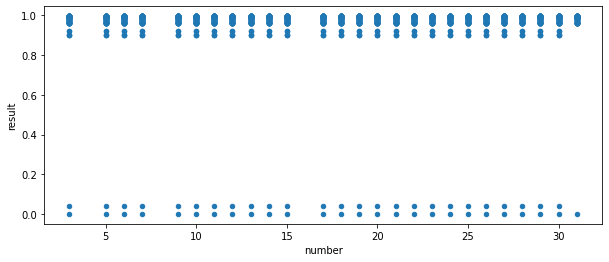

In [112]:
import pandas as pd
df = pd.read_csv('results.csv')
print(df.head())

df = pd.DataFrame(data = df)

df.plot(x ='number', y='result', kind = 'scatter', figsize=(10,4))

plt.show()
